# 4. Exploratory Analysis 

This notebook examines the input variables available in the cleaned dataset. Univariate distributions and bivariate relationships will be explored. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
# Read in aggregated drug mortality data
opioid_us = pd.read_csv('./data/US_drug_mort_census_num.csv')
opioid_us['dm_log_mean'] = np.log(opioid_us['dm_mean'] + 0.1)
#opioid_us.info()

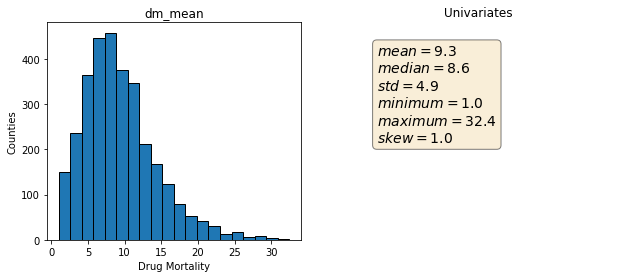

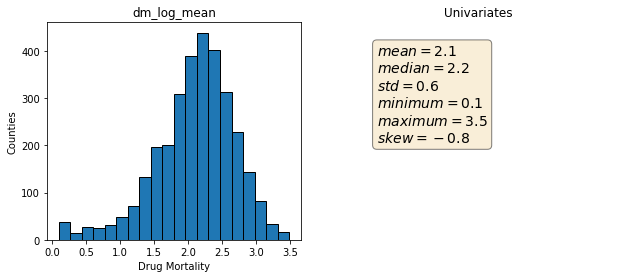

In [3]:
# Look at distribution of new outcome variable - mean drug mortality, and also its log
varlist = ['dm_mean', 'dm_log_mean']

#Generate univariate measures and histogram for each variable in list
for var in varlist:
    v_mean = opioid_us[var].mean()
    v_median = opioid_us[var].median()
    v_std = opioid_us[var].std()
    v_min = opioid_us[var].min()
    v_max = opioid_us[var].max()
    v_skew = opioid_us[var].skew()
    textstr = '$mean=%.1f$\n$median=%.1f$\n$std=%.1f$\n$minimum=%.1f$\n$maximum=%.1f$\n$skew=%.1f$' % (v_mean, v_median, v_std, v_min, v_max, v_skew)

    figure1, (ax1, ax2) = plt.subplots(1, 2)
    figure1.set_size_inches(10, 4, forward=True)
  
    plt.title(var);
    ax1.hist(opioid_us[var].dropna(), edgecolor = 'k', bins = 20)
    ax1.set_xlabel("Drug Mortality")
    ax1.set_ylabel("Counties")
    ax1.set_title(var)
    
    
    #ax2.hist(opioid_us[var].dropna(), edgecolor = 'k', bins = 20)
    # place a text box in upper left in axes coords
    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax2.text(0.10, 0.90, textstr, fontsize=14, verticalalignment='top', bbox=props)
    ax2.grid(False)
    ax2.axis('off')
    plt.title("Univariates");
    plt.show()

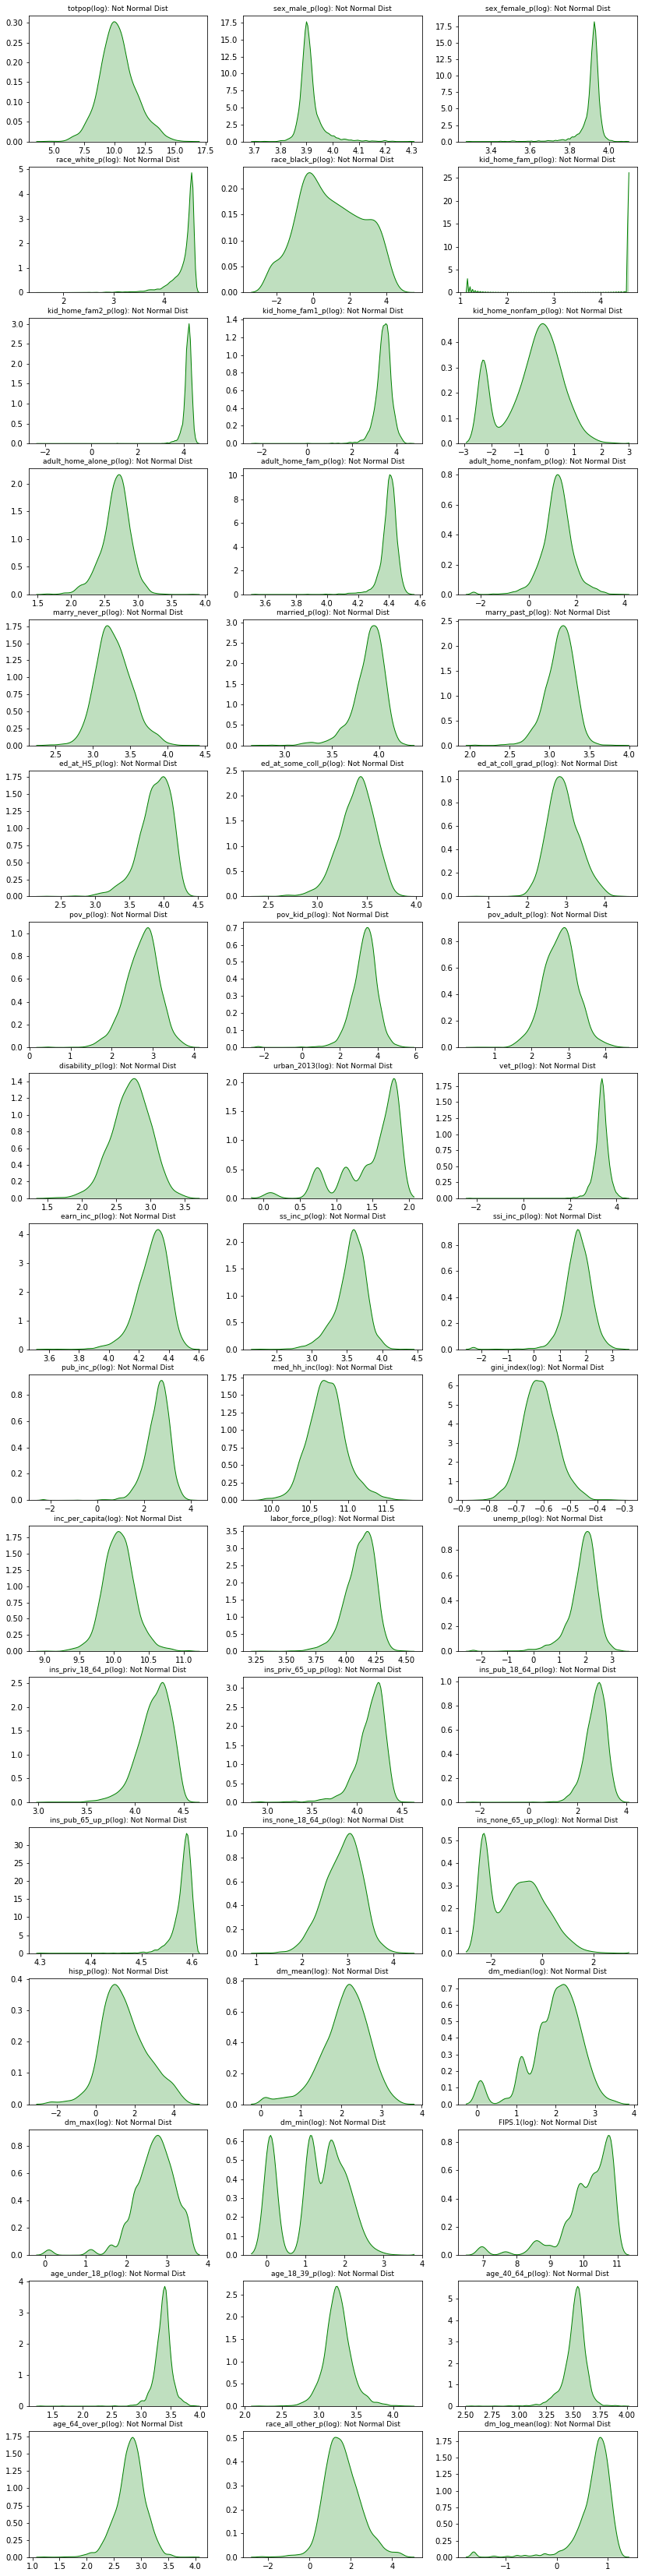

In [4]:
# Review distributions of potential predictor variables
fig = plt.figure()

num=0
for column in  opioid_us.drop(columns = ['FIPS']):
    #Create normal test indicator
    k2, p = stats.normaltest(np.log(opioid_us[column]+.1))
    alpha = 1e-3
    if p < alpha:  # null hypothesis: x comes from a normal distribution
        v_normal = "Not Normal Dist"
    else:
        v_normal = "Normal Dist"
    num+=1
    
    # Find the right spot on the plot
    plt.subplot(17, 3, num)
    fig.set_size_inches(14, 60, forward=True)
    
    plot_var =  np.log(opioid_us[column]+.1)    
    sns.kdeplot(plot_var.dropna(), shade=True, linewidth=1, legend=False, color='g') #
    title = column + "(log): " + v_normal
    plt.title(title, fontsize=9)
      
plt.show()      

#### Above are density plots for all numeric variables (logged). Many of these distributions are not normal, but taking the log has reduced the skewness for many of them (not shown).

#### The variable urban_2013 is a ranked measure of urbanization, which can also be treated as a categorical variable (1=city, 6=rural).

In [5]:
opioid_us.urban_2013.value_counts()

6.0    1332
5.0     641
3.0     370
2.0     366
4.0     358
1.0      68
Name: urban_2013, dtype: int64

#### Nearly half of US counties are rural and only 68/3135 or 2% are large cities. However, over 30% of the population lives in large cities while only about 6% live in the most rural areas.

In [6]:
opioid_us.groupby('urban_2013').totpop.agg(np.sum)

urban_2013
1.0    96933880
2.0    78894846
3.0    65415634
4.0    29055145
5.0    27224355
6.0    18977008
Name: totpop, dtype: int64

## 4.2 Correlations Among Numeric Variables

In [7]:
opioid_num = opioid_us.drop(columns=['FIPS', 'FIPS.1', 'dm_log_mean', 'dm_median', 'dm_min', 'dm_max', 'urban_2013'])

In [8]:
# Take log of all the numeric data in input data, due to skewness
opioid_log = pd.DataFrame()
for col in opioid_num.columns:
    opioid_log[col] = np.log(opioid_num[col] + 0.1)
# Merge urban cat/ord variable back in    
opioid_log = pd.concat([opioid_log, opioid_us['urban_2013']], axis=1)  

In [9]:
# Generate correlations for plotting
corr = opioid_log.corr()
dm_corr = corr['dm_mean']
dm_corr.pop('dm_mean')
dm_corr_abs = dm_corr.abs()
dm_corr_df = pd.DataFrame(dm_corr)
dm_corr_df = dm_corr_df.rename(columns={'dm_mean':'corr'})
dm_corr_df = pd.concat([dm_corr_df, dm_corr_abs], axis=1)
dm_corr_df = dm_corr_df.rename(columns={'dm_mean':'abs'})
top_corr = dm_corr_df.sort_values(by=['abs'], ascending=False).head(20).reset_index()
top_corr_vars = top_corr['index']
top_corr_vars=top_corr_vars.tolist()
top_corr_vars.append('dm_mean')
top_corr_data = opioid_log[top_corr_vars]


In [10]:
#top_corr[['corr', 'index']]

The table below lists the 20 features with the highest correlations with drug mortality. We can see that the county-level factors associated with drug mortality in some ways echo the 'deaths of despair' framework that emerged from the exploratory work of [Case and Deaton](https://www.brookings.edu/past-bpea-editions/). Their work focuses on the characteristics of *people* with high drug mortality rates, whereas this county-level analysis uses data on communities. At the community level the strongest relationships seem to be with facets of economic disadvantage and stagnation, including rates of unemployment, use of public assistance, lack of private insurance, and poverty. We can also see an association between drug mortality and indicators of weakened social support, including rates of adults and children living in non-family households, adults who are previously married (i.e., divorced or widowed), and physical disabilities. Finally, we see a small positive relationship between drug mortality and the percent Black, which is surprising considering that race-specific death rates make clear that the opioid epidemic has had far greater impact on whites in the US (see Case and Deaton above). I suspect that this is likely to be a spurious correlation correlation caused by the fact that more urbanized counties in the US have higher proportions of Black residents.

| Correlation | Feature Name        | Description                                             |
|-------------|---------------------|---------------------------------------------------------|
| 0.474638    | unemp_p             | Unemployment rate                                       |
| 0.431599    | ins_pub_18_64_p     | Percent of adults with public insurance                 |
| 0.400171    | totpop              | Population                                              |
| 0.387905    | ssi_inc_p           | Percent of households with Supplemental Security Income |
| 0.385667    | pub_inc_p           | Percent of households with public assistance            |
| -0.343611   | labor_force_p       | Labor force participation rate                          |
| 0.340851    | marry_past_p        | Percent of adults married in the past                   |
| 0.318582    | disability_p        | Percent of adults with a disability                     |
| -0.318407   | earn_inc_p          | Percent of households with earned income                |
| 0.291051    | pov_kid_p           | Child poverty rate                                      |
| 0.278506    | kid_home_fam1_p     | Percent of children living in single-parent households  |
| -0.272750   | ins_priv_18_64_p    | Percent of adults with private insurance                |
| 0.260372    | pov_p               | Poverty rate (overall)                                  |
| 0.241284    | pov_adult_p         | Poverty rate (adults)                                   |
| 0.236611    | adult_home_nonfam_p | Percent of adults living in non-family households       |
| 0.208037    | kid_home_nonfam_p   | Percent of children living in non-family households     |
| -0.205553   | urban_2013          | Urbanization category (1=city thru 6=rural)             |
| 0.166502    | ins_none_18_64_p    | Percent of adults with no insurance                     |
| 0.162094    | race_black_p        | Percent Black                                           |
| 0.150648    | ss_inc_p            | Percent of households with Social Security income       |


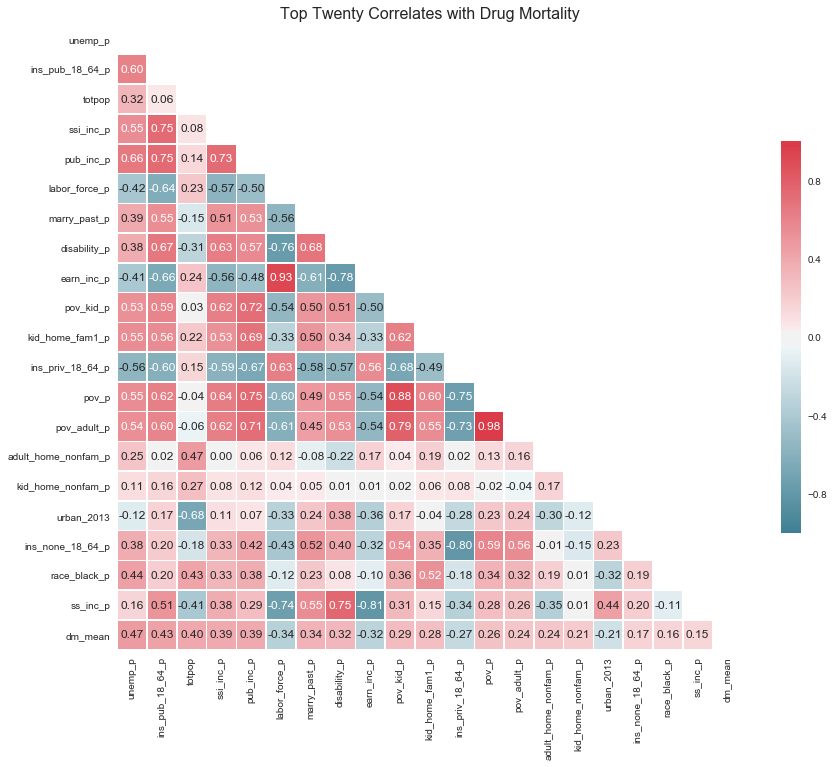

In [11]:
# Heat map correlation matrix 
# Economic Indicators

sns.set(style="white")

# Compute the correlation matrix
corr = top_corr_data.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(14, 12))
ax.set_title('Top Twenty Correlates with Drug Mortality', fontsize=16)

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=True, fmt=".2f", mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0, cbar_kws={"shrink": .6}, ax=ax, 
            square=True, linewidths=.5) ;



The above matrix shows correlations between mean drug mortality and the top 20 correlates. The correlations with drug mortality can be seen along the bottom row. Many of these predictor variables are also higly correlated with each other.

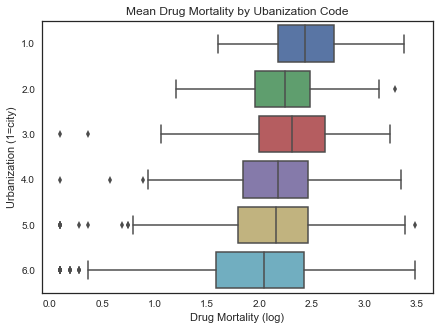

In [12]:
#plt.subplot()
fig, ax = plt.subplots()
fig.set_size_inches(7, 5, forward=True)
sns.boxplot(x='dm_mean', y='urban_2013', data=opioid_log, linewidth=1.5, orient='h')
plt.title('Mean Drug Mortality by Ubanization Code')
ax.set_xlabel("Drug Mortality (log)")
ax.set_ylabel("Urbanization (1=city)")
plt.show()

In the above box plot we can see differences in the distribution of mean drug mortality according to level of urbanization. While the mean does seem to vary in a not-quite-linear way across categories, what is most noticeable is the much greater variance of drug mortality among rural counties. Rural counties are home to both the highest and lowest mean drug mortality rates in the US. The next step will be to examine some scatter plots for nonlinear relationships.

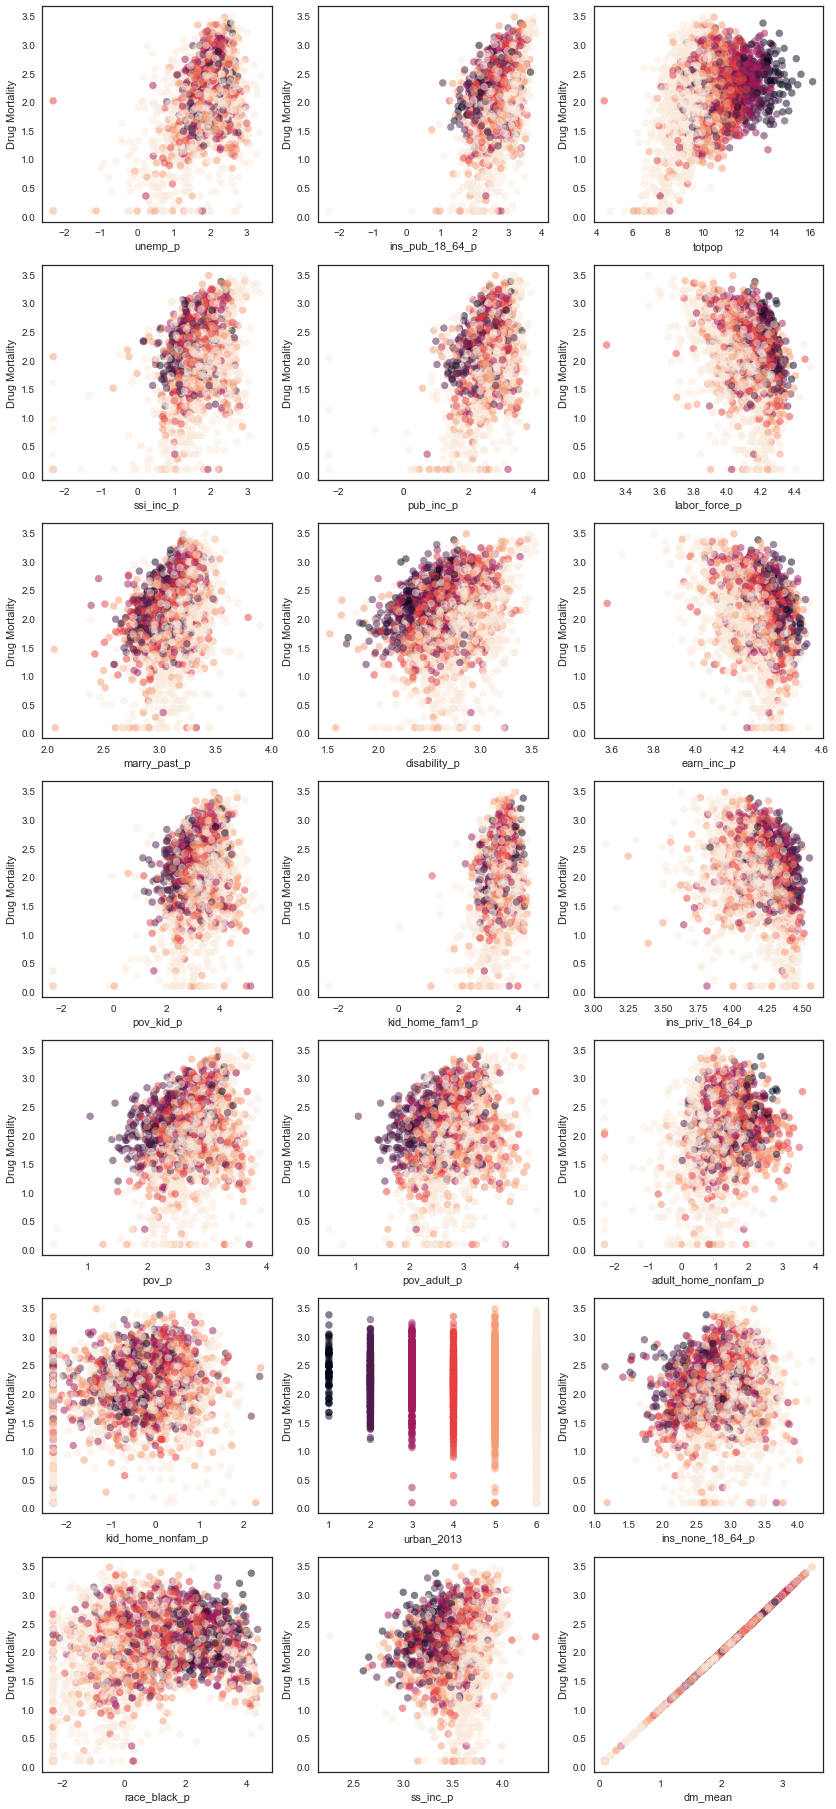

In [13]:
fig = plt.figure()

num=0
for column in  top_corr_data:
    num+=1
    
    # Find the right spot on the plot
    plt.subplot(17, 3, num)
    fig.set_size_inches(14, 80, forward=True)
    textstr = '$%s:$\n$mean=%.3f$\n$std=%.3f$' % (v_normal, v_mean, v_std)

    #plt.ylim(0, .9)
    
    plot_var =  top_corr_data[column]
    plt.scatter(plot_var, top_corr_data.dm_mean, alpha=.5, c=top_corr_data.urban_2013)   
    plt.xlabel(column)
    plt.ylabel("Drug Mortality")
       
plt.show()    

The scatterplots above, which depict the top 20 correlates of drug mortality, have the urbanization code added to the color axis of the plot (1=city/dark thru 6=rural/light), which reveals some interesting patterns and possible interactions. For example, for the features measuring disability status, poverty, and insurance status, it appears that there is a higher baseline for drug mortality in urban counties and possibly a stronger connection between these variables in urban counties as compared to rural counties. For the percent Black in a county's population, we see a possibly non-linear relationship with drug mortality in which urban counties tend to have higher Black populations and also higher (and less variable) drug mortality rates. These interactions suggest that linear models may not be able to fit this data well. 